# TELCO CHURN ANALYSIS

## Hypothesis

Null Hypothesis: There is no relationship between the monthly charges and the churn of customers.

Alternate Hypothesis: There is a relationship between the monthly charges and the churn of customers.

## Analytical Questions
1. What is the overall churn rate of the telecommunication company?
2. What is the average monthly charges to churn customers compared to non-churn customers?
3. What percentage of the top 100 most charged customers churned?
4. What percentage of the top 100 least charged customers churned?
5. What is the churn rate of male customers with partners, dependents and high monthly charges?
6. What is the churn rate of customers without online security?
7. What is the churn rate of customers without online backup?
8. What is the churn rate of customers without device protection?
9. What is the churn rate of customers without Tech support?
10. How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?
11. How does the length of customers' contract affect their likelihood of churn?
12. How does the length of customers' tenure affect their likelihood of churn?

In [92]:
# Importing the needed packages
import pandas as pd
import numpy as np

# Libraries to create connection string to SQL server
import pyodbc
from dotenv import dotenv_values

# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for testing the hypothesis
import scipy.stats as stats

# Library for splitting the train data
from sklearn.model_selection import train_test_split

# Library for features scaling
from sklearn.preprocessing import MinMaxScaler

# Libraries for balancing the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Libraries for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings

warnings.filterwarnings('ignore')

There are three datasets for this analysis which are located in three different places. The first dataset can be found on a SQL server and is to be accessed remotely. The second dataset can be found as an excel file on One Drive. The access link was provided and used to access and download the dataset. While the third dataset can be found as a csv file on a Github repository whose link was provided as well and used to clone the dataset into the local machine.

The first and last datasets have been identified as the train datasets, while the second dataset has been identifed as the test dataset. The train datasets will be assessed and merged together, and used to build models independently. While the test dataset will be used to test the models independently.

## Accessing the first dataset from SQL database

In [93]:
# Load the environment variable in the .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# The connection string is an f string that includes all the variable above to extablish a connection to the server.
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


In [94]:
# Using the connect method of the pyodbc library to pass in the connection string.

# N/B: This will connect to the server and might take a few seconds to be complete.
# Check your internet connection if it takes more time than necessary.

connection = pyodbc.connect(connection_string)

In [95]:
# Get the dataset using the SQL query shown below
# dbo.LP2_Telco_churn_first_3000 is the name of the dataset, dbo being a naming convention in Microsoft SQL Server.

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df1 = pd.read_sql(query, connection)

df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## Accessing the last dataset

In [5]:
# Loading the last dataset.

df3 = pd.read_csv('LP2_Telco-churn-last-2000.csv')

In [6]:
# Displaying the first five rows of the last dataset.

df3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [7]:
# Inspecting the columns of the first dataset.

df1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
# Inspecting the columns of the last dataset.

df3.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
# Since both datasets have the same column names and index number, they can be concatenated to have the train dataset.

train_data = pd.concat([df1, df3])

# Saving the train dataset to a new csv file.
train_data.to_csv('Train-Data.csv')

train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## Accessing the second dataset (test dataset)

In [10]:
# Loading the test dataset.

test_data = pd.read_excel('Telco-churn-second-2000.xlsx')
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## EDA

In [11]:
# Checking the number of rows and columns on the train dataset.

train_data.shape

(5043, 21)

In [12]:
# Checking the number of rows and columns on the test dataset.

test_data.shape

(2000, 20)

The train dataset has 5043 columns and 21 columns while the test dataset has 2000 rows and 20 columns. Let's identify the column in the train dataset that is absent in the test dataset.

In [13]:
# Inspecting the columns of the train dataset.

train_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [14]:
# Inspecting the columns of the test dataset.

test_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

As can be seen, the test dataset has the same columns as the train dataset with the exception of the churn column which can be found on the train dataset alone. This is understandable as the churn column on the train dataset provides information on whether customers churn or  not, which is used to build the best ML model. This column is not needed on the test dataset, rather the model built is tested on the test dataset to check the ability of the model to predict whether a customet will churn or not.

In [15]:
# Checking the datatypes and the presence of missing values on the train dataset.

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   object 
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [16]:
# Checking the datatypes and the presence of missing values on the test dataset.

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


Note that the datatype of the 'SeniorCitizen' column is an object on the train data but an integer on the test data.

In [17]:
# Confirming the number of cells with missing values on each column of the train dataset.

train_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

The 'MultipleLines' column has 269 missing values. The 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV' and 'StreamingMovies' columns all have 651 missing values. This needs to be evaluated further to find out if these missing values are exactly on the same rows. The 'TotalCharges' column has 5 missing values while the 'Churn' column has 1 missing value.

In [18]:
# Confirming that there are no missing values on the test dataset.

test_data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

There are no missing values on the test dataset.

In [19]:
# Checking for the presence of duplicates on the train dataset.

train_data.duplicated().sum()

0

There are no duplicate rows on the train dataset.

In [20]:
# Checking for the presence of duplicates on the test dataset.

test_data.duplicated().sum()

0

There are no duplicate rows on the test dataset.

# Data Transformation

In [21]:
# Investigating the columns on the train dataset.

train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: [False True]
column: Partner - unique value: [True False 'No' 'Yes']
column: Dependents - unique value: [False True 'No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: [False True 'Yes' 'No']
column: MultipleLines - unique value: [None False True 'No' 'No phone service' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: [False True None 'No' 'Yes' 'No internet service']
column: OnlineBackup - unique value: [True False None 'No' 'Yes' 'No internet service']
column: DeviceProt

There are many coloumns with unnecessary values such as True, False, 'No phone service' and/or  'No internet service'.
These values will be replaced with 'Yes' or 'No' as appropriate to ensure consistency.

True will be replaced with 'Yes' because True means that the customers receive those services. While False, 'No phone service' and 'No internet service' will be replaced with 'No' because they mean that the customers do not (or cannot) receive those services. 

In [22]:
# Replace True with 'Yes' and replacing False, 'No internet service' and 'No phone service' with 'No' in the train dataset.

train_data = train_data.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace = False)

# Confirming that the changes on the train dataset have been effected.

train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: ['No' 'Yes']
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: [None 'No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes' None]
column: OnlineBackup - unique value: ['Yes' 'No' None]
column: DeviceProtection - unique value: ['No' 'Yes' None]
column: TechSupport - unique value: ['No' 'Yes' None]
column: StreamingTV - unique value

None is the Boolean representation of missing values. The columns with None are all categorical columns. The mode of these columns will be obtained and used to replace None.

In [23]:
# Replace None on each column with the mode of the column.

def replace_none_with_mode(train_data):
   categorical_cols = train_data.select_dtypes(include='object').columns  # Select categorical columns

   for col in categorical_cols:
       mode_val = train_data[col].mode()[0]  # Calculate the mode of the column
       train_data[col] = train_data[col].replace({None: mode_val})  # Replace None values with the mode

   return train_data
train_data = replace_none_with_mode(train_data)

# Confirming that the changes on the train dataset have been effected.

train_data.columns
for column in train_data.columns:
    print('column: {} - unique value: {}'.format(column, train_data[column].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: ['No' 'Yes']
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: ['No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['Yes' 'No']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['No' 'Yes']
column: St

In [24]:
# Drop the customerID column from the train dataset since it has unique values that are non-beneficial to our modelling

train_data.drop(columns='customerID', inplace=True)

In [25]:
# Checking for missing values on the train dataset.

train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The train dataset no longer has missing values. This is because None values (which is a boolean representation of missing values) has been changed to No.

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

Total Charges column has an object datatype. This needs to be converted to float to enable us do some calculations on the column. The column will be investigated to see some of its features.

In [27]:
# Investigating the 'TotalCharges' column in the train dataset.

train_data['TotalCharges'].unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [28]:
# Converting the datatype of the 'TotalCharges' column in the train dataset to float by changing the contents to
# numerical values.


train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors = 'coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

In [29]:
# Checking for missing values

train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
Churn               0
dtype: int64

The 'TotalCharges' column now has three missing values. These will be replaced with the mean value since it's now a numerical column.

In [30]:
# Calculate the mean of the 'TotalCharges' column
mean_value = train_data['TotalCharges'].mean()

# Fill missing values with the mean value
train_data['TotalCharges'] = train_data['TotalCharges'].fillna(mean_value)

# Confirm that their are no missing values
train_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [31]:
# Evaluating the categorical values on the train dataset.

train_data.describe(include = ['O'])

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043,5043
unique,2,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,2559,4224,2585,3482,4554,2913,2248,3587,3311,3299,3552,3098,3061,2744,2996,1700,3707


In [32]:
# Evaluating the numerical values on the train dataset.

train_data.describe()

,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2299.799108
std,24.529807,30.068133,2268.819487
min,0.000000,18.400000,18.799999
25%,9.000000,35.775000,416.650000
50%,29.000000,70.550003,1400.849976
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


In [33]:
# Evaluating the correlation of the numerical values on the train dataset.

train_data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.240645,0.826017
MonthlyCharges,0.240645,1.000000,0.646841
TotalCharges,0.826017,0.646841,1.000000


<Axes: >

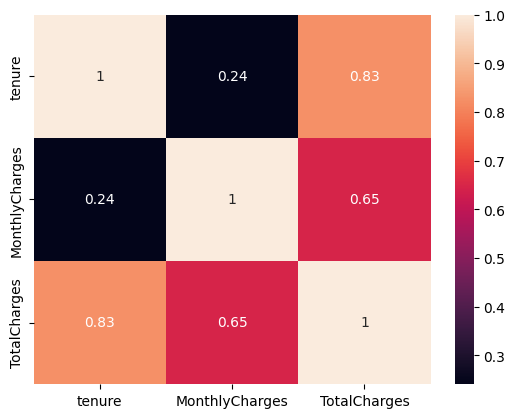

In [34]:
# Visualizing the correlation with a heatmap

sns.heatmap(train_data[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True)

Since there are calculations to be done on the 'Churn' column of the train dataset, 'No' and 'Yes' values will be changed to 0 and 1 respectively in order to convert the column to a numerical column.

In [35]:
# Changing 'No' and 'Yes' to 0 and 1 respectively on the 'Churn' column of the train dataset.

train_data['Churn'] = train_data['Churn'].replace(['No', 'Yes'], [0,1])
train_data['Churn'].unique()

array([0, 1], dtype=int64)

# Hypothesis Testing

Hypothesis
Null Hypothesis: There is no relationship between the monthly charges and the churn of customers.

Alternate Hypothesis: There is a relationship between the monthly charges and the churn of customers.

The hypothesis was tested using chi-square test.

In [36]:
# Define the null hypothesis.
null_hypothesis = "There is no relationship between the monthly charge and churn of customers."

# Define the alternative hypothesis.
alternative_hypothesis = "There is a relationship between the monthly charge and churn of customers."

# Perform the chi-square test
observed = pd.crosstab(train_data['MonthlyCharges'], train_data['Churn'])

chi2, p_value, _, _ = stats.chi2_contingency(observed)


# Set the significance level
alpha = 0.05


# Print the test results
print("Null Hypothesis:", null_hypothesis)

print("Alternative Hypothesis:", alternative_hypothesis)

print("Significance Level (alpha):", alpha)

print("Chi-square statistic:", chi2)

print("P-value:", p_value)


# Compare the p-value with the significance level
if p_value < alpha:

    print("Result: Reject the null hypothesis. There is a relationship between the monthly charges and churn of customers.")

else:

    print("Result: Fail to reject the null hypothesis. There is no relationship between monthly charges and churn of customers.")

Null Hypothesis: There is no relationship between the monthly charge and churn of customers.
Alternative Hypothesis: There is a relationship between the monthly charge and churn of customers.
Significance Level (alpha): 0.05
Chi-square statistic: 2435.9382488559727
P-value: 2.9228176168391307e-08
Result: Reject the null hypothesis. There is a relationship between the monthly charges and churn of customers.


# Answering Questions with Visualizations

###  Analytical Questions
1. What is the overall churn rate of the telecommunication company?
2. What is the average monthly charges to churn customers compared to non-churn customers?
3. What percentage of the top 100 most charged customers churned?
4. What percentage of the top 100 least charged customers churned?
5. What is the churn rate of male customers with partners, dependents and high monthly charges?
6. What is the churn rate of customers without online security?
7. What is the churn rate of customers without online backup?
8. What is the churn rate of customers without device protection?
9. What is the churn rate of customers without Tech support?
10. How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?
11. How does the length of customers' contract affect their likelihood of churn?
12. How does the length of customers' tenure affect their likelihood of churn?

# Question 1
What is the overall churn rate of the telecommunication company?

Total Customers: 5043
Churned Customers: 1336
Churn Rate: 26.5%


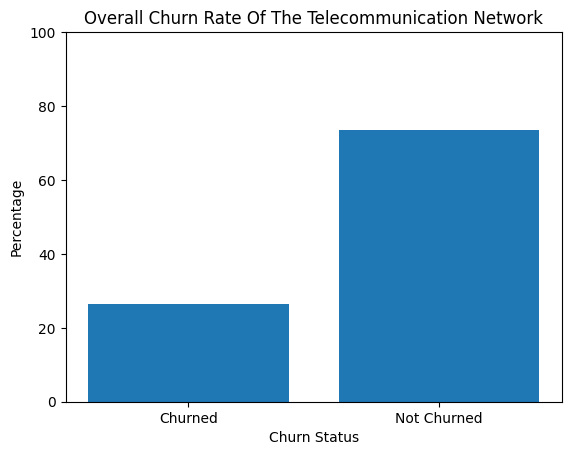

In [37]:
# Calculate the churn rate
total_customers = len(train_data)
churned_customers = train_data['Churn'].sum()
churn_rate = (churned_customers / total_customers) * 100

# Display the churn rate
print('Total Customers:', total_customers)
print('Churned Customers:', churned_customers)
print(f'Churn Rate: {churn_rate.round(1)}%')

# Plot the churn rate
plt.bar(['Churned', 'Not Churned'], [churn_rate, 100-churn_rate])
plt.title('Overall Churn Rate Of The Telecommunication Network')
plt.xlabel('Churn Status')
plt.ylabel('Percentage')
plt.ylim([0, 100])
plt.show()

With 5043 customers initially out of which 1336 have churned, the telecommunication network has a churn rate of 26.5%.

# Question 2
What is the average monthly charges to churn customers compared to non-churn customers?

Average Monthly Charges To Churn Customers: $75.21
Average Monthly Charges To Non-Churn Customers: $61.44


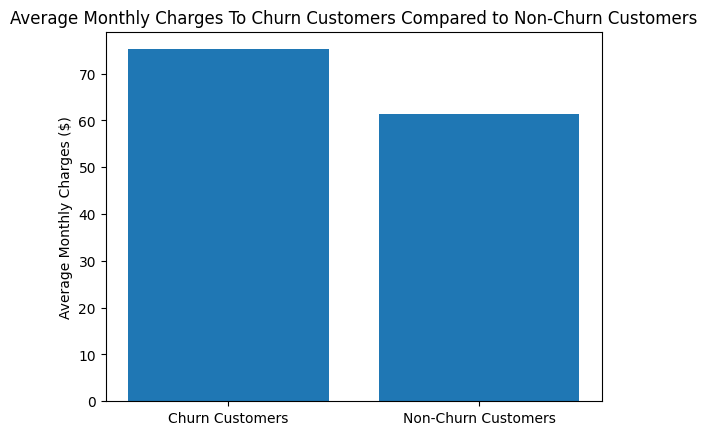

In [38]:
# Separate churn and non-churn customers
churn_customers = train_data[train_data['Churn'] == 1]
non_churn_customers = train_data[train_data['Churn'] == 0]

# Calculate the average monthly charges for churn and non-churn customers
avg_churn_charges = churn_customers['MonthlyCharges'].mean()
avg_non_churn_charges = non_churn_customers['MonthlyCharges'].mean()

# Display the average charges
print(f'Average Monthly Charges To Churn Customers: ${round(avg_churn_charges, 2)}')
print(f'Average Monthly Charges To Non-Churn Customers: ${round(avg_non_churn_charges, 2)}')

# Plot the average charges
labels = ['Churn Customers', 'Non-Churn Customers']
charges = [avg_churn_charges, avg_non_churn_charges]
plt.bar(labels, charges)
plt.ylabel('Average Monthly Charges ($)')
plt.title('Average Monthly Charges To Churn Customers Compared to Non-Churn Customers')
plt.show()

As shown, the average monthly charges to churn customers is 75.21 dollars, higher than the average monthly charges to non-churn customers (61.44 dollars).

# Question 3
What percentage of the top 100 most charged customers churned?

The Percentage Of The Top 100 Most Charged Customers Who Churned: 7.000000000000001%


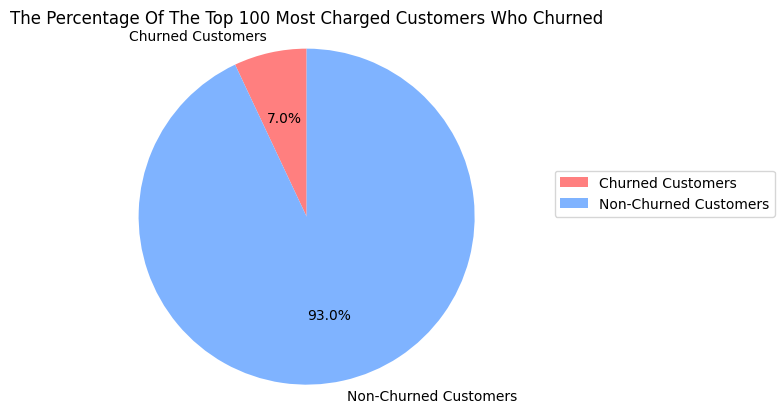

In [39]:
# Sort the DataFrame by TotalCharges in descending order

most_charged_data = train_data.sort_values(by='TotalCharges', ascending=False)

# Select the top 100 most charged customers
top_100_most_charged_customers = most_charged_data.head(100)

# Count the number of churned customers among the top 100
most_charged_churned_customers = top_100_most_charged_customers[top_100_most_charged_customers['Churn'] == 1]
most_charged_churned_count = most_charged_churned_customers.shape[0]

# Calculate the percentage of churned customers
most_charged_percentage_churned = (most_charged_churned_count / 100) * 100

# Display the result
print(f'The Percentage Of The Top 100 Most Charged Customers Who Churned: {most_charged_percentage_churned}%')

# Create a pie chart to visualize the results
labels = ['Churned Customers', 'Non-Churned Customers']
sizes = [most_charged_percentage_churned, 100 - most_charged_percentage_churned]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the top 100 most charged customers who churned
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('The Percentage Of The Top 100 Most Charged Customers Who Churned')
plt.legend(loc=(1,0.5))
plt.show()

At an overall churn rate of 26.5%, only 7% of the top 100 most charged customers churned. This suggests that the total charges are not the only determinant of churn. There will be other factors that influenced the churn rate.

# Question 4
What percentage of the top 100 least charged customers churned?

The Percentage Of The Top 100 Least Charged Customers Who Churned: 33.0%


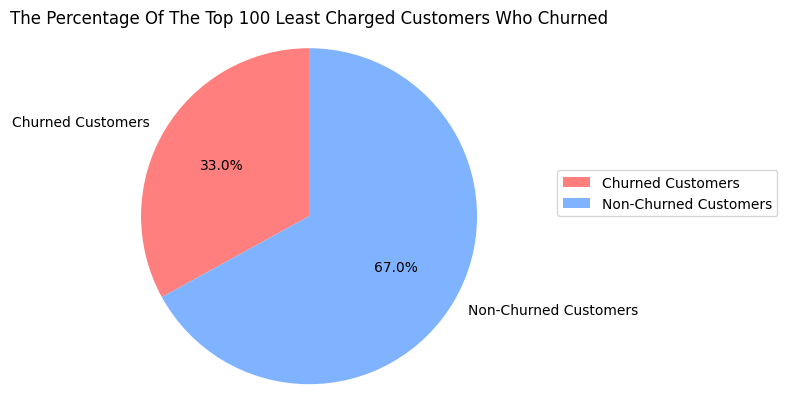

In [40]:
# Sort the DataFrame by TotalCharges in ascending order

least_charged_data = train_data.sort_values(by='TotalCharges', ascending=True)

# Select the top 100 least charged customers
top_100_least_charged_customers = least_charged_data.head(100)

# Count the number of churned customers among the top 100
least_charged_churned_customers = top_100_least_charged_customers[top_100_least_charged_customers['Churn'] == 1]
least_charged_churned_count = least_charged_churned_customers.shape[0]

# Calculate the percentage of churned customers
least_charged_percentage_churned = (least_charged_churned_count / 100) * 100

# Display the result
print(f'The Percentage Of The Top 100 Least Charged Customers Who Churned: {least_charged_percentage_churned}%')

# Create a pie chart to visualize the results
labels = ['Churned Customers', 'Non-Churned Customers']
sizes = [least_charged_percentage_churned, 100 - least_charged_percentage_churned]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the top 100 most charged customers who churned
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('The Percentage Of The Top 100 Least Charged Customers Who Churned')
plt.legend(loc=(1,0.5))
plt.show()

33% of the top 100 least charged customers churned. This strenghtens the argument that the charges are not the only determinant of churn. A good number of those that got the least charges churned although the charges they paid were reasonably low.

# Question 5
What is the churn rate of male customers with partners, dependents and high monthly charges?

N/B: It is assumed that high monthly charges refer to monthly charges equal to or above $100.

Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: 20.0%
Non-Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: 80.0%


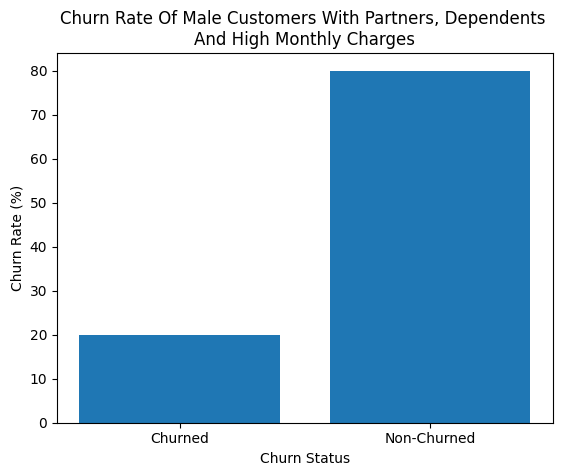

In [41]:
# Filter the data to include only male customers with partners and dependents and high monthly charges
filtered_train_data = train_data[(train_data['gender'] == 'Male') & (train_data['Partner'] == 'Yes') & (train_data['Dependents'] == 'Yes') & (train_data['MonthlyCharges'] > 100)]

# Calculate the churn rate.
rate_churned = filtered_train_data[filtered_train_data['Churn'] == 1].shape[0]/len(filtered_train_data) * 100

# Calculate the non-churn rate.
rate_non_churned = filtered_train_data[filtered_train_data['Churn'] == 0].shape[0]/len(filtered_train_data) * 100

# Display the result
print(f'Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: {rate_churned}%')
print(f'Non-Churn Rate of Male Customers with Partners, Dependents and High Monthly Charges: {rate_non_churned}%')

# Create a bar plot to visualize the churn rate and non-churn rate.
labels = ['Churned', 'Non-Churned']
charges = [rate_churned, rate_non_churned]

# Plot the churn rate of male customers with partners, dependents and high monthly charges
plt.bar(labels, charges)
plt.xlabel('Churn Status')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate Of Male Customers With Partners, Dependents \nAnd High Monthly Charges')
plt.show()

On the assumption that male customers with partners and dependents have higher financial demands to meet under average conditions, this question analyzed the rate at which high charges influenced the churn rate of this set of customers. It was discovered that only 20% of male customers with partners, dependents and high monthly charges churned. This confirms that the charges are not the only determinant of churn. There are other factors that greatly influenced the churn rate.

# Question 6
What is the churn rate of customers without online security?

Churn Rate Of Customers Without Online Security: 31.27962085308057%


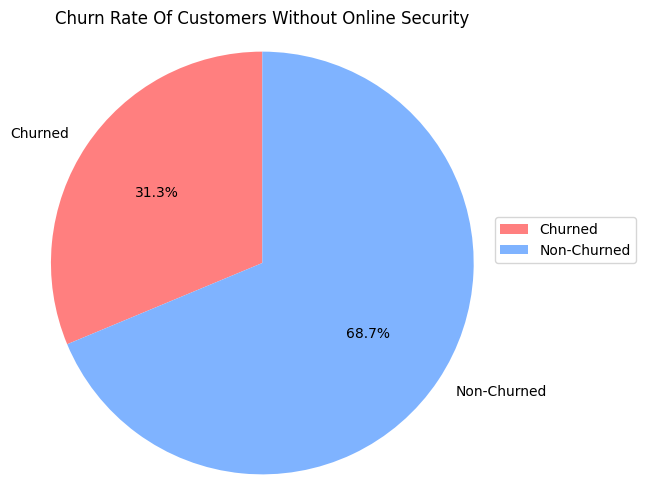

In [42]:
# Filter the DataFrame to include only customers without online security
no_security_customers = train_data[train_data['OnlineSecurity'] == 'No']

# Calculate the churn rate of customers without online security
churned_customers = no_security_customers[no_security_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_security_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Online Security: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without online security
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Online Security')
plt.legend(loc=(1,0.5))
plt.show()

31.3% of customers without online security churned. This means that the absence of online security influenced the churn rate of customers.

# Question 7
What is the churn rate of customers without online backup?

Churn Rate Of Customers Without Online Backup: 29.205678042887346%


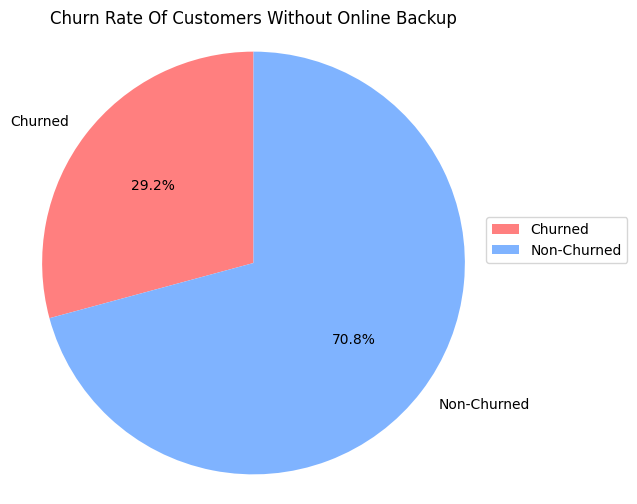

In [43]:
# Filter the DataFrame to include only customers without online backup
no_backup_customers = train_data[train_data['OnlineBackup'] == 'No']

# Calculate the churn rate of customers without online backup
churned_customers = no_backup_customers[no_backup_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_backup_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Online Backup: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without online backup
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Online Backup')
plt.legend(loc=(1,0.5))
plt.show()

29.2% of customers without online backup churned. This means that the absence of online backup influenced the churn rate of customers.

# Question 8
What is the churn rate of customers without device protection?

Churn Rate Of Customers Without Device Protection: 28.58441952106699%


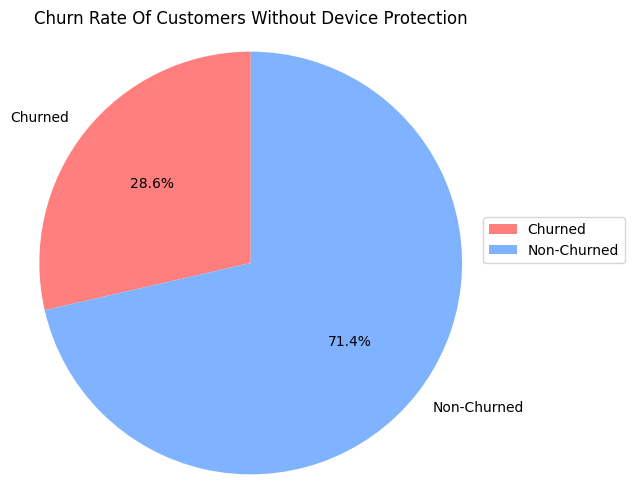

In [44]:
# Filter the DataFrame to include only customers without device protection
no_device_protection_customers = train_data[train_data['DeviceProtection'] == 'No']

# Calculate the churn rate of customers without device protection
churned_customers = no_device_protection_customers[no_device_protection_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_device_protection_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Device Protection: {churned_rate}%')

# Create a pie chart to visualize the results
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without device protection
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Device Protection')
plt.legend(loc=(1,0.5))
plt.show()

28.6% of customers without device protection churned. This means that the absence of device protection influenced the churn rate of customers.

# Question 9
What is the churn rate of customers without Tech support?

Churn Rate Of Customers Without Tech Support: 31.390765765765767%


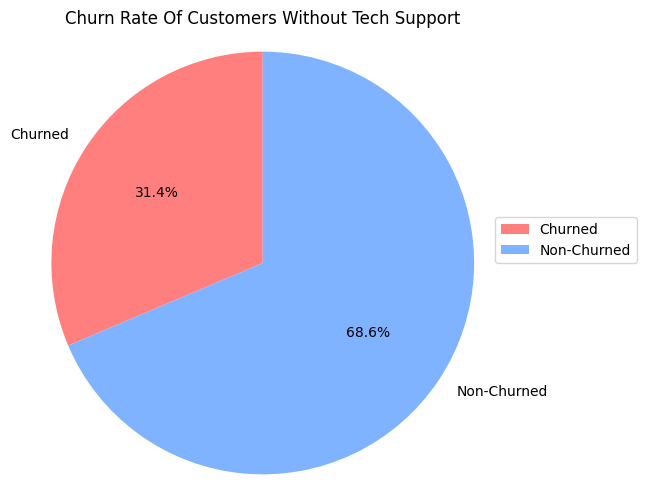

In [45]:
# Filter the DataFrame to include only customers without Tech support
no_tech_support_customers = train_data[train_data['TechSupport'] == 'No']

# Calculate the churn rate of customers without Tech support
churned_customers = no_tech_support_customers[no_tech_support_customers['Churn'] == 1]
churned_rate = (churned_customers.shape[0] / no_tech_support_customers.shape[0]) * 100

# Display the result
print(f'Churn Rate Of Customers Without Tech Support: {churned_rate}%')

# Create a pie chart to visualize the result
labels = ['Churned', 'Non-Churned']
sizes = [churned_rate, 100 - churned_rate]
colors = ['#FF7F7F', '#7FB3FF']

# Plot the churn rate of customers without Tech support
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Churn Rate Of Customers Without Tech Support')
plt.legend(loc=(1,0.5))
plt.show()

31.4% of customers without Tech support churned. This means that the absence of Tech support influenced the churn rate of customers.

# Question 10
How does the absence of online security, online backup, device protection and Tech support add up to lead to churning?

Churn Percentage Of Customers Without Online Security: 83.98203592814372%
Churn Percentage Of Customers Without Online Backup: 72.38023952095809%
Churn Percentage Of Customers Without Device Protection: 70.58383233532935%
Churn Percentage Of Customers Without Tech Support: 83.45808383233533%


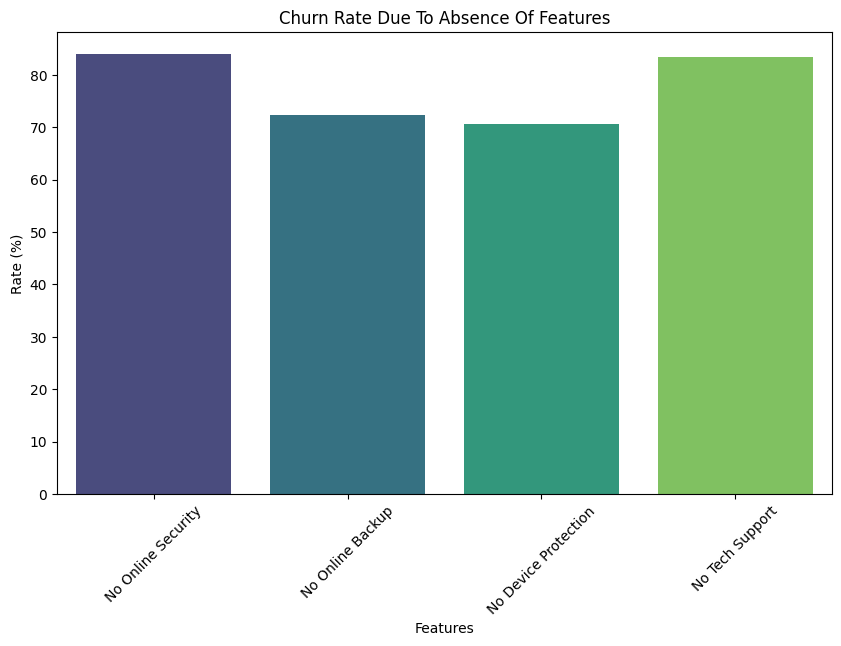

In [46]:
# Calculate the number of churned customers based on absence of each feature
churned_customers = train_data[train_data['Churn'] == 1]

absence_of_security = churned_customers[churned_customers['OnlineSecurity'] == 'No'].shape[0]
absence_of_backup = churned_customers[churned_customers['OnlineBackup'] == 'No'].shape[0]
absence_of_protection = churned_customers[churned_customers['DeviceProtection'] == 'No'].shape[0]
absence_of_tech_support = churned_customers[churned_customers['TechSupport'] == 'No'].shape[0]

# Calculate the rate at which the absence of each feature contributes to churning
total_churned_customers = churned_customers.shape[0]

rate_of_security = (absence_of_security / total_churned_customers) * 100
rate_of_backup = (absence_of_backup / total_churned_customers) * 100
rate_of_protection = (absence_of_protection / total_churned_customers) * 100
rate_of_tech_support = (absence_of_tech_support / total_churned_customers) * 100

# Display the results
print(f'Churn Percentage Of Customers Without Online Security: {rate_of_security}%')
print(f'Churn Percentage Of Customers Without Online Backup: {rate_of_backup}%')
print(f'Churn Percentage Of Customers Without Device Protection: {rate_of_protection}%')
print(f'Churn Percentage Of Customers Without Tech Support: {rate_of_tech_support}%')

# Create a bar plot to visualize the results
labels = ['No Online Security', 'No Online Backup', 'No Device Protection', 'No Tech Support']
rates = [rate_of_security, rate_of_backup, rate_of_protection, rate_of_tech_support]

# Plot the rate at which the absence of each feature contributes to churning
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=rates, palette='viridis')
plt.title('Churn Rate Due To Absence Of Features')
plt.xlabel('Features')
plt.ylabel('Rate (%)')
plt.xticks(rotation=45)
plt.show()

This means that out of all the churned customers, 84.0% did not have online security, 72.4% did not have online backup, 70.6% did not have device protection, and 83.5% did not have Tech support. These factors are majorly responsible for churning.

# Question 11
How does the length of customers' contract affect their likelihood of churn?

Contract Lengths: ['Month-to-month' 'One year' 'Two year']
Churn Rates: [43.14868804664723, 11.563981042654028, 2.4115755627009645]


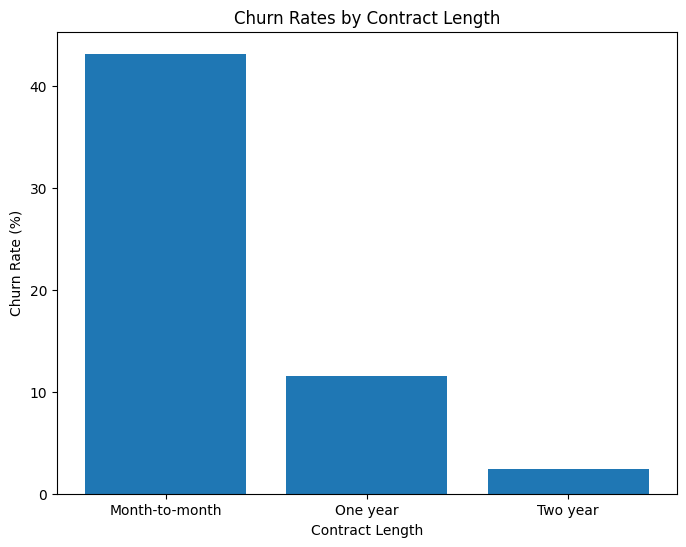

In [47]:
# Calculate churn rates for different contract lengths
contract_lengths = train_data['Contract'].unique()
churn_rates = []

for length in contract_lengths:
   churn_rate = train_data[train_data['Contract'] == length]['Churn'].value_counts(normalize=True).get(1, 0) * 100
   churn_rates.append(churn_rate)

# Display the contract lenghts and churn rates
print(f'Contract Lengths: {contract_lengths}')
print(f'Churn Rates: {churn_rates}')

# Create a bar plot to visualize the churn rates by contract length
plt.figure(figsize=(8, 6))
plt.bar(contract_lengths, churn_rates)
plt.xlabel('Contract Length')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rates by Contract Length')
plt.show()

As shown, the length of a customer's contract affects the churn rate. Customers with month-to-month contract have a high churn rate of 43.1%. This is followed by customers with one year contract length with a churn rate of 11.6%. While customers with two year contract length have a low churn rate of 2.4%.

# Question 12
How does the length of customers' tenure affect their likelihood of churn?

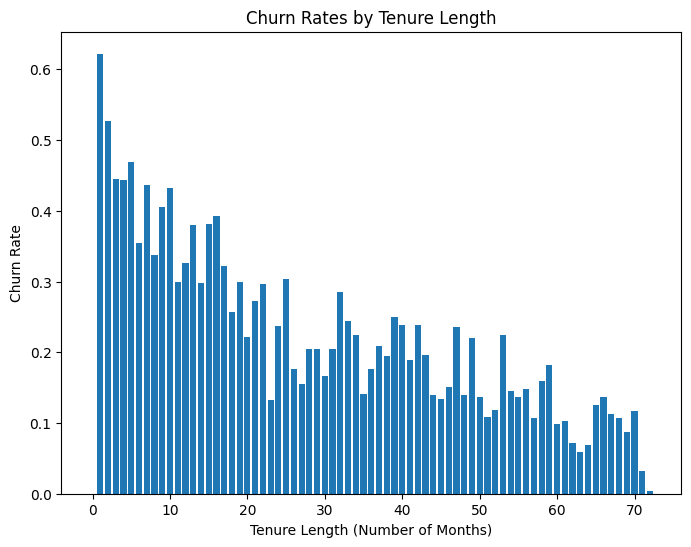

In [48]:
# Calculate churn rates for different tenure lengths
tenure_lengths = train_data['tenure'].unique()
churn_rates = []

for length in tenure_lengths:
   churn_rate = train_data[train_data['tenure'] == length]['Churn'].value_counts(normalize=True).get(1, 0)
   churn_rates.append(churn_rate)

# Create a bar plot to visualize the churn rates by tenure length
plt.figure(figsize=(8, 6))
plt.bar(tenure_lengths, churn_rates)
plt.xlabel('Tenure Length (Number of Months)')
plt.ylabel('Churn Rate')
plt.title('Churn Rates by Tenure Length')
plt.show()

As shown, the more the tenure length (number of months) a customer stays with the telecommunication company, the lower the likelihood of churn. This is ralated to the result of the likelihood of churn based on the contract length of customers.

# Recommendation

In [49]:
#

In [50]:
# # Pandas Profiling
# # TRAIN

# profile = ProfileReport(train_data, title = "Train Dataset", html = {'style': {full_width: True}})
# profile.to_notebook_iframe()
# profile.to_file('(Trainset) Pandas-Profiling_Report.html')

# Feature Engineering

In [51]:
# First create a copy of the train dataset on which to carry out the feature engineering processes

train_data_transformed = train_data.copy()

### Feature scaling with MinMaxScaler

In [52]:
# Select the numerical columns for scaling
features_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply Min-Max scaling to the selected features
train_data_transformed[features_to_scale] = scaler.fit_transform(train_data_transformed[features_to_scale])

# View the scaled data
train_data_transformed[features_to_scale].head()

,tenure,MonthlyCharges,TotalCharges
0,0.013889,0.114214,0.001277
1,0.472222,0.384539,0.216233
2,0.027778,0.353616,0.010328
3,0.625000,0.238404,0.210598
4,0.027778,0.521696,0.015356


### Label encoding

In [53]:
# Select the categorical binary columns for label encoding
label_encoding_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
                          'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'PaperlessBilling']

# Encode categorical binary columns using label encoding
for column in label_encoding_columns:

   if column == 'gender':
       train_data_transformed[column] = train_data_transformed[column].map({'Female': 1, 'Male': 0})
   else:
       train_data_transformed[column] = train_data_transformed[column].map({'Yes': 1, 'No': 0})

# Show the results
train_data_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,0.013889,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,0.114214,0.001277,0
1,0,0,0,0,0.472222,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,0.384539,0.216233,0
2,0,0,0,0,0.027778,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,0.353616,0.010328,1
3,0,0,0,0,0.625000,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),0.238404,0.210598,0
4,1,0,0,0,0.027778,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,0.521696,0.015356,1


### One-hot encoding

In [54]:
# Select categorical columns with more than two levels (two unique values) for one-hot encoding
one_hot_encoding_columns = ['InternetService', 'Contract', 'PaymentMethod']

# Encode categorical columns with more than two levels (two unique values) using one-hot encoding
train_data_transformed = pd.get_dummies(train_data_transformed, columns=one_hot_encoding_columns)

# Show the results
train_data_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,0.013889,0,0,0,1,0,...,True,False,False,True,False,False,False,False,True,False
1,0,0,0,0,0.472222,1,0,1,0,1,...,True,False,False,False,True,False,False,False,False,True
2,0,0,0,0,0.027778,1,0,1,1,0,...,True,False,False,True,False,False,False,False,False,True
3,0,0,0,0,0.625000,0,0,1,0,1,...,True,False,False,False,True,False,True,False,False,False
4,1,0,0,0,0.027778,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False


# Splitting the train dataset

In [55]:
X = train_data_transformed.drop('Churn', axis=1)
y = train_data_transformed['Churn']

# Split train dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the train dataset
print("Train set shape:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Train set shape: (4034, 26) (4034,) (1009, 26) (1009,)


# Balancing the dataset

In [56]:
# Perform oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Perform undersampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Print the class distribution before and after balancing
print("Before balancing:")
print(y_train.value_counts())

print("After balancing:")
print(pd.Series(y_train_resampled).value_counts())

Before balancing:
Churn
0    2965
1    1069
Name: count, dtype: int64
After balancing:
Churn
0    1069
1    1069
Name: count, dtype: int64


# Model Training and Evaluation

In [83]:
# Create a list of models to train and evaluate
models = [
    ('Logistic Regression', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, criterion='gini', min_samples_leaf=8, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)),
    ('Support Vector Machine', SVC(random_state=42, kernel='rbf', C=1.0)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
]

# Create an empty DataFrame to store our performance metrics
performance_metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC_AUC'])

#knn, svm, lr, dt, rf, 
# Model training, evaluation and result calculation
for model_name, model in models:
    # Model training
    model.fit(X_train, y_train)
    
    # Using models to make predictions on validation set
    y_pred = model.predict(X_val)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    
    # Store the calculation results in the performance metrics DataFrame
    performance_metrics = performance_metrics._append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC_AUC': roc_auc
    }, ignore_index=True)

# Print the performance metrics DataFrame
performance_metrics

,Model,Accuracy,Precision,Recall,F1 Score,ROC_AUC
0,Logistic Regression,0.800793,0.634146,0.584270,0.608187,0.731488
1,Decision Tree,0.776016,0.576208,0.580524,0.578358,0.713443
2,Random Forest,0.789891,0.636816,0.479401,0.547009,0.690509
3,Gradient Boosting,0.795837,0.629787,0.554307,0.589641,0.718528
4,Support Vector Machine,0.795837,0.628692,0.558052,0.591270,0.719727
5,Gaussian Naive Bayes,0.736373,0.501193,0.786517,0.612245,0.752423
6,K-Nearest Neighbors,0.765114,0.556391,0.554307,0.555347,0.697639


Based on the f1 score of the models, Guassian Naive Bayes is the best model with an f1 score of 0.612245.

# Confusion Matrix

# Hyper-parameter tuning